In [1]:
import os, random
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

class TireDataset(Dataset):
    """Tire dataset."""

    def __init__(self, csv_file, img_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            img_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.tire_frame = pd.read_csv(csv_file, sep=";", encoding='ISO-8859-1', decimal=',')
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.tire_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Anton Comment :)
        # This ensures that the image that's read by the TireDataset class matches on name, not index
        img_name = os.path.join(self.img_dir, self.tire_frame.iloc[idx, 0])
        image = Image.open(img_name)
        depth = self.tire_frame.iloc[idx, 1]
        depth = torch.tensor(float(depth), dtype=torch.float) 

        if self.transform:
            image = self.transform(image)

        return image, depth, self.tire_frame.iloc[idx, 0]
    

def show_images_with_depths(dataset, num_images=5):
    """
    Displays the first `num_images` images from the dataset with their corresponding depths.
    
    Args:
        dataset (Dataset): The dataset from which to show images.
        num_images (int): The number of images to display.
    """
    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))
    
    # Generate a list of random indices
    indices = random.sample(range(len(dataset)), num_images)
    
    for i, idx in enumerate(indices):
        image, depth, img_name = dataset[idx]  # Retrieve data using a random index
        
        ax = axes[i]
        ax.imshow(image.permute(1, 2, 0))
        ax.set_title(f'{img_name}\nDepth: {depth.item()}', fontsize=10)
        ax.axis('off')

    plt.show()


In [22]:
# Anton Comment :)
# Define a transform to preprocess the images
# Here I think we can be a bit more creative with the data augmentation such as different lighting conditions, add noise, or apply geometric transformations. 
# I also believe that most resnet model has been trained with normalized image data, which might be something to consider as well
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to a different size (Can be as Adnan did with 256, or 1080 as Fehzan did)
    transforms.ToTensor(), 
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # This bit is for normalization of mean and standard deviation for ImageNet - please double check
])

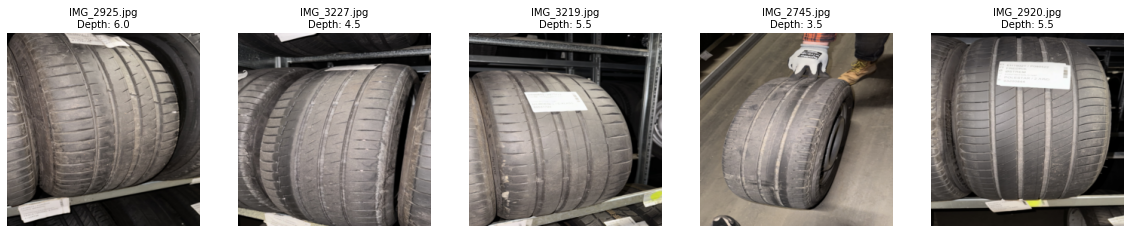

In [21]:
# Create the dataset and display 5 images with name and depth
tire_dataset = TireDataset(csv_file='Labels.csv', img_dir='Dataset', transform=transform)
show_images_with_depths(tire_dataset, num_images=5)

### *Note*
This function sometimes returns an error, which leads me to belive that some images are missing from the Dataset folder

In [4]:
def find_missing_images(dataset):
    """
    Loops through the dataset and returns a list of image names that are missing.
    
    Args:
        dataset (Dataset): The dataset to check for missing images.
        
    """
    missing_images = []
    
    for idx in range(len(dataset)):
        img_name = os.path.join(dataset.img_dir, dataset.tire_frame.iloc[idx, 0])
        # Check if the image file exists
        if not os.path.isfile(img_name):
            missing_images.append(dataset.tire_frame.iloc[idx, 0])
    
    return missing_images

# Find and print missing images
missing_images = find_missing_images(tire_dataset)
print(f"Number of missing images: {len(missing_images)}")
print(f"Percentage of missing images: {round((len(missing_images) / len(tire_dataset)), 2)*100}%")


Number of missing images: 95
Percentage of missing images: 11.0%


In [17]:
#Exclude missing images from dataset - for now 
csv_file = 'Labels.csv'  # Update this path
data = pd.read_csv(csv_file, sep=";", encoding='ISO-8859-1', decimal=',')

filtered_data = data[~data['Img_name'].isin(missing_images)]

filtered_csv_file = 'filtered_csv_file.csv'
filtered_data.to_csv(filtered_csv_file, index=False, sep=";")
filtered_data = filtered_data.dropna(subset=['Depth'])

In [12]:
def plot_depth_distribution(data: pd.DataFrame):
    depths = data['Depth']
    depth_counts = depths.value_counts()
    depth_counts = depth_counts.reset_index().sort_values(by='index')
    depth_counts.columns = ['Depth', 'Frequency']
    plt.figure(figsize=(10, 6))
    plt.bar(depth_counts['Depth'].astype(str), depth_counts['Frequency'])
    plt.title('Distribution of Depth Values in the Dataset')
    plt.xlabel('Depth')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()

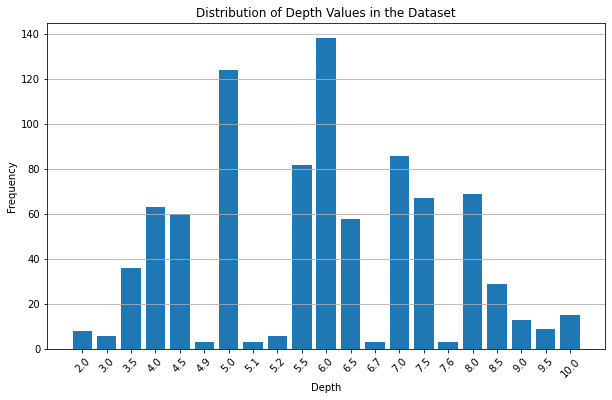

In [14]:
# Complete set
plot_depth_distribution(data)

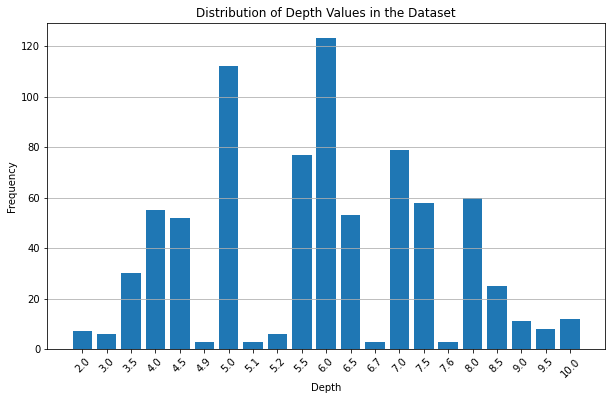

In [16]:
# Subset without any missing images
plot_depth_distribution(filtered_data)

# Distribution comments
Seems ok in the range, but few outliers - consider overfitting